In [4]:
from datetime import datetime
import requests
import clickhouse_connect
import logging
import sys
import boto3
from botocore.exceptions import ClientError, EndpointConnectionError
import pandas as pd
from io import BytesIO
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, when, upper, trim, concat_ws, sha2, lit, unix_timestamp, round
from pyspark.sql.types import FloatType, LongType
import socket

In [5]:
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# File storage config
bronze_storage = {'path': 'http://localhost:9000/', 'user': 'minioadmin', 'pass': 'minioadmin', 'bucket': 'nyc-taxi-raw-data'}
clickhouse_storage = {'path': 'http://localhost:9000/', 'user': 'minioadmin', 'pass': 'minioadmin', 'bucket': 'nyc-taxi-db'}

# Folder with SQL scripts
sql_scripts_folder = 'sql'

# Clickhouse server config
clickhouse_host = 'def-clickhouse'
clickhouse_port = '8123'
clickhouse_user = 'default'
clickhouse_password = 'admin'
clickhouse_staging_db_name = 'nyc_taxi_staging'
clickhouse_silver_db_name = 'nyc_taxi_silver'
clickhouse_gold_db_name = 'nyc_taxi_datamarts'

# Base URL of source data files
raw_data_base_link = 'https://d37ci6vzurychx.cloudfront.net/trip-data/'

# URL of taxi zones lookup table
lookup_table_file_name = 'taxi_zone_lookup.csv'
lookup_table_file_url = 'https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv'

# Spark master config
spark_master = 'spark://spark-master:7077'

In [6]:
def check_db_existance(ch_client, db_name):
    """
    Checks if database with db_name exists
    """
    sql = f"""
        SELECT COUNT(*)
            FROM system.databases
        WHERE name='{db_name}'
    """

    try:
        result = bool(ch_client.query(sql).result_rows[0][0])
        logging.info(f'Database {db_name} exists: {result}')
        return result
    except Exception as e:
        logging.error(f'Error checking database: {e}')
    
    return False

In [7]:
def create_db(ch_client, db_name):
    """
    Creates tabase with db_name
    """
    sql= f"""
        CREATE DATABASE iF NOT EXISTS {db_name}
    """
    
    try:
        ch_client.command(sql)
        logging.info(f'Database {db_name} created successfully')
    except Exception as e:
        logging.error(f'Error creating database: {e}')

    return check_db_existance(ch_client, db_name)

In [8]:
def check_storage(storage_name):
    """
    Checks if storage exists and bucket is accessible with provided credentials and tries to create if it doesn't exist
    """
    try:
        s3 = boto3.client(
            's3',
            endpoint_url=storage_name['path'],
            aws_access_key_id=storage_name['user'],
            aws_secret_access_key=storage_name['pass']
        )

        s3.head_bucket(Bucket=storage_name['bucket'])
        logging.info(f"Bucket {storage_name['bucket']} is accessible.")

        return True

    except EndpointConnectionError as e:
        logging.error(f'Cannot connect to endpoint: {e}')
    except ClientError as e:
        logging.error(f'S3 error: {e}')

        # If bucket doesn't exist - try to create
        if int(e.response['Error']['Code']) == 404:
            logging.error(f"Bucket {storage_name['bucket']} not found — creating...")

            try:
                s3.create_bucket(Bucket=storage_name['bucket'])
                print(f"Bucket {storage_name['bucket']} created.")
            except Exception as ee:
                logging.error(f"Cannot create bucket {storage_name['bucket']}. Error: {ee}")

    except Exception as e:
        logging.error(f'Error checking storage: {e}')

    return False

In [10]:
# Check existance of necessary storages
for storage in [bronze_storage, clickhouse_storage]:
    check_storage(storage)


INFO:root:Bucket nyc-taxi-raw-data is accessible.
INFO:root:Bucket nyc-taxi-db is accessible.


In [11]:
# Try to connect to ClickHouse instance
try:
    clickhouse_client = clickhouse_connect.get_client(
        host=clickhouse_host,
        port=clickhouse_port,
        username=clickhouse_user,
        password=clickhouse_password)
    logging.info(f'Connected to Clickhouse successfully.')
except Exception as e:
    logging.error(f'Error connecting to Clickhouse: {e}')
    

INFO:root:Connected to Clickhouse successfully.


In [ ]:
def create_db_schema(ch_client, db_name, sql_scripts):
    """
    Creates neccessary tables in database db_name, if they don't exist.
    Runs scripts to populate some tables
    """
    # Select database
    try:
        ch_client.command(f'USE {db_name};')
    except Exception as e:
        logging.error(f'Error selecting database {db_name}: {e}')
    
    logging.info(f'Creating schema for database {db_name}, if not exists')

    # For each script load it from file and execute
    for script in sql_scripts:
        with open(f'{sql_scripts_folder}/{script}', 'r', encoding='utf-8') as file:
            sql = file.read()


        # Get individual commands from script
        for cmd in sql.split(';'):
            cmd = cmd.strip()
            if cmd:
                try:
                    # Execute command
                    ch_client.command(cmd)
                except Exception as e:
                    logging.error(f'Error creating schema for database {db_name}: {e}')

In [13]:
def check_schema(ch_client, db_name):
    logging.info(f'Checking database {db_name} schema')

    if db_name == clickhouse_staging_db_name:
        sql_scripts = ['staging.sql']
    elif db_name == clickhouse_silver_db_name:
        sql_scripts = ['silver.sql', 'populate_vendors.sql', 'populate_rates.sql', 'populate_payment_types.sql', 'populate_trip_types.sql', 'populate_taxi_types.sql']
    elif db_name == clickhouse_gold_db_name:
        sql_scripts = ['gold.sql',
            'populate_payment_gold.sql',
            'populate_distances.sql',
            'populate_durations.sql',
            'mv_top_zones.sql',
            'mv_rides_by_hour.sql',
            'mv_weekdays_by_hour.sql',
            'mv_weekends_by_hour.sql',
            'mv_trip_categories.sql',
            'mv_trip_vectors.sql'
            ]
    else:
        logging.error(f'Wrong database name!')
        return False
    
    create_db_schema(ch_client, db_name, sql_scripts)

In [16]:
# Check existance of necessary databases
for db in [clickhouse_staging_db_name, clickhouse_silver_db_name, clickhouse_gold_db_name]:
    # If database doesn't exist - create database
    if not check_db_existance(clickhouse_client, db):
        logging.info(f'Database {db} not found.')
        if not create_db(clickhouse_client, db):
            logging.error('Cannot create database!')

    # Check database schema
    check_schema(clickhouse_client, db)
    

INFO:root:Database nyc_taxi_staging exists: True
INFO:root:Checking database nyc_taxi_staging schema
INFO:root:Creating schema for database nyc_taxi_staging, if not exists
INFO:root:Database nyc_taxi_silver exists: True
INFO:root:Checking database nyc_taxi_silver schema
INFO:root:Creating schema for database nyc_taxi_silver, if not exists
INFO:root:Database nyc_taxi_datamarts exists: True
INFO:root:Checking database nyc_taxi_datamarts schema
INFO:root:Creating schema for database nyc_taxi_datamarts, if not exists


In [11]:
def get_downloaded_files(ch_client, db_name, file_name=''):
    """
    Get list of already downloaded files from database
    (may be different from list of files in the bucket)
    If file_name parameter is present - returns only corresponding records
    """

    sql = f"""
        SELECT file_name
            FROM {db_name}.bronze_files
    """
    
    # If file_name is present - add filter by file name
    if file_name:
        sql += f" WHERE file_name = '{file_name}'"

    try:
        result = ch_client.query(sql).result_rows
        files_list = [r[0] for r in result]

        return files_list
        
    except Exception as e:
        logging.error(f'Error getting downloadded files list: {e}')
    


In [12]:
def write_file_info_to_db(ch_client, db_name, file_name, file_url, id='NULL'):
    """
    Writes or updates information on downloaded file into staging database table
    Table bronze_files uses ReplacingMergeTree
    """
    
    sql = f"""
        INSERT INTO {db_name}.bronze_files (file_name, source_url, taxi_type_id)
            VALUES ('{file_name}', '{file_url}', {id})
    """

    try:
        ch_client.command(sql)
        logging.info(f'File {file_name} information saved to database {db_name}')
    except Exception as e:
        logging.error(f'Error while saving file {file_name} information to database {db_name}: {e}')
    

In [13]:
def download_file(file_url, storage):
    """
    Downloads file from given URL and saves to given storage
    """
    try:
        headers = {
            'Referer': 'https://www.nyc.gov/',
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8',
            #'Accept-encoding': 'gzip, deflate, br, zstd',
        }
        
        with requests.get(file_url, headers=headers, stream=True) as file:
            # If status is not 2xx - raise error
            file.raise_for_status()

            # Extract file name from URL
            file_name = file_url.split('/')[-1]

            try:
                s3 = boto3.client(
                    's3',
                    endpoint_url=storage['path'],
                    aws_access_key_id=storage['user'],
                    aws_secret_access_key=storage['pass']
                )
                s3.upload_fileobj(file.raw, storage['bucket'], file_name)
                logging.info(f"File {file_name} uploaded to storage {storage['path']}{storage['bucket']}")

                return True
            except Exception as ee:
                    logging.error(f"Error saving file {file_name} to storage {storage['path']}{storage['bucket']}. Error: {ee}")
        
    except Exception as e:
        logging.error(f'Error downloading file {file_url}: {e}')
    
    return False

In [14]:
def mark_file_processed(ch_client, db_name, file_name):
    """
    Set field 'processed' in table bronze_files as True for given file
    The table uses ReplacingMergeTree engine, so we use INSERT to update
    """

    sql = f"""
        ALTER TABLE {db_name}.bronze_files
        UPDATE processed = True,
            processed_dt = now()
        WHERE file_name = '{file_name}';
    """

    try:
        ch_client.command(sql)
        logging.info(f'File {file_name} marked as processed.')
    except Exception as e:
        logging.error(f'Error marking file {file_name} as processed: {e}')

In [284]:
def insert_taxi_zones_into_db(ch_client, file_name, storage, silver_db, gold_db):
    """
    Insert the data from file with lookuptaxi zones lookup table
    into silver and gold layers
    """
    
    logging.info(f'Inserting data from file {file_name} into databases.')

    try:
        s3 = boto3.client(
            's3',
            endpoint_url=storage['path'],
            aws_access_key_id=storage['user'],
            aws_secret_access_key=storage['pass']
        )

        file = s3.get_object(Bucket=storage['bucket'], Key=file_name)

        # Make panadas dataframe from csv for further processing
        csv_data = file['Body'].read()
        df = pd.read_csv(BytesIO(csv_data))

        # Drop duplicates
        df = df.drop_duplicates(subset=['LocationID'])
        # Add 'source' field
        df['source'] = lookup_table_file_url
        # Cast data types just in case
        df['LocationID'] = df['LocationID'].astype(int)
        df['Borough'] = df['Borough'].astype(str)
        df['Zone'] = df['Zone'].astype(str)
        df['service_zone'] = df['service_zone'].astype(str)
        # Add boolean field "is_airport"
        df['is_airport'] = df['Zone'].str.contains('airport', case=False, na=False)

        # Write data into databases
        for db in [silver_db, gold_db]:
            # Check existig IDs
            if db == silver_db:
                table_name = 'taxi_zone_details'
                id_col = 'taxi_zone_id'
            else:
                table_name = 'dim_taxi_zone'
                id_col = 'taxi_zone_id'

            sql = f'SELECT {id_col} FROM {db}.{table_name}'
            result = ch_client.query(sql)
            existing_ids = set(row[0] for row in result.result_rows)

            # In new dataframe leave only unique rows
            new_rows = df[~df['LocationID'].isin(existing_ids)]

            # If new rows are present - write them into tables
            if not new_rows.empty:
                # Insert new rows
                # For silver layer
                if db == silver_db:
                    data_to_insert = [tuple(x) for x in new_rows[['LocationID', 'Borough', 'Zone', 'service_zone', 'source']].to_numpy()]
                    ch_client.insert(f'{db}.{table_name}', data_to_insert, column_names=[id_col, 'borough', 'zone', 'service_zone', 'record_source'])

                # For golden layer
                else:
                    data_to_insert = [tuple(x) for x in new_rows[['LocationID', 'Borough', 'Zone', 'is_airport', 'source']].to_numpy()]
                    ch_client.insert(f'{db}.{table_name}', data_to_insert, column_names=[id_col, 'borough', 'zone', 'is_airport', 'record_source'])

                logging.info(f'Taxi zones uploaded into database {db}')
            else:
                logging.info(f'There are no new records in lookup table for database {db}')

        # Mark lookup file as processed
        mark_file_processed(ch_client, clickhouse_staging_db_name, file_name)

    except Exception as e:
        logging.error(f'Error loading taxi zones data into database {db}: {e}')



In [17]:
# Download lookup table if it is not downloaded already
if not len(get_downloaded_files(clickhouse_client, clickhouse_staging_db_name, lookup_table_file_name)):
    # Don't use function download_file for this file as it uses streming download
    try:
        response = requests.get(lookup_table_file_url)
        response.raise_for_status()

        s3 = boto3.client(
            's3',
            endpoint_url=bronze_storage['path'],
            aws_access_key_id=bronze_storage['user'],
            aws_secret_access_key=bronze_storage['pass']
        )

        s3.upload_fileobj(BytesIO(response.content), bronze_storage['bucket'], lookup_table_file_name)
        logging.info(f"File {lookup_table_file_name} uploaded to storage {bronze_storage['path']}{bronze_storage['bucket']}")
        
        write_file_info_to_db(clickhouse_client, clickhouse_staging_db_name, lookup_table_file_name, lookup_table_file_url)
    except Exception as e:
        logging.error(f'Error downloading lookup table {lookup_table_file_url}: {e}')
else:
    logging.info(f'Taxi zones lookup table is already downloaded')

INFO:root:File taxi_zone_lookup.csv uploaded to storage http://localhost:9000/nyc-taxi-raw-data
INFO:root:File taxi_zone_lookup.csv information saved to database nyc_taxi_staging


In [285]:
# Upload the data into silver layer
insert_taxi_zones_into_db(clickhouse_client, lookup_table_file_name, bronze_storage, clickhouse_silver_db_name, clickhouse_gold_db_name)

INFO:root:Inserting data from file taxi_zone_lookup.csv into databases.
INFO:root:There are no new records in lookup table for database nyc_taxi_silver
INFO:root:Taxi zones uploaded into database nyc_taxi_datamarts
INFO:root:File taxi_zone_lookup.csv marked as processed.


In [19]:
def get_taxi_types(ch_client, silver_db):
    """
    Get ID and file prefix of taxi company from table taxi_type_details
    """
    sql = f"""
        SELECT taxi_type_id, file_prefix
            FROM {silver_db}.taxi_type_details
    """

    result = ch_client.query(sql)
    taxi_types = tuple(result.named_results())

    return taxi_types

In [20]:
print(get_taxi_types(clickhouse_client, clickhouse_silver_db_name))

({'taxi_type_id': 0, 'file_prefix': 'yellow'}, {'taxi_type_id': 1, 'file_prefix': 'green'})


In [255]:
# Download raw data file for each month from the last upload
start_date = datetime.strptime('2017-01-01', '%Y-%m-%d')
start_year = int(start_date.year)
start_month = int(start_date.month)

end_date = datetime.now()
cur_year = int(end_date.year)
cur_month = int(end_date.month)

# Construct a file name for each month and download it
tmp_counter = 0

# Getting the list of already downloaded files
# Checking all files every time the DAG runs allows to download them in any order
# and not rely on specific order (as if getting maximum date etc)
# Keeping information in the table instead of checking existance in the bucket
# allows to drop older processed files wothout them being downloaded again
downloaded_files_list = get_downloaded_files(clickhouse_client, clickhouse_staging_db_name)

taxi_types = get_taxi_types(clickhouse_client, clickhouse_silver_db_name)

for year in range(start_year, cur_year + 1):
    # Set month boundary for the month iteration
    if year == cur_year:
        end_month = cur_month
    else:
        end_month = 12

    for month in range(start_month, end_month + 1):
        for taxi in taxi_types:
            raw_data_file_name = f"{taxi['file_prefix']}_tripdata_{year}-{month:02d}.parquet"
            raw_data_url = raw_data_base_link + raw_data_file_name

            # If that file has already been downloaded - get next one
            if raw_data_file_name in downloaded_files_list:
                continue;

            logging.info(f'Downloading file {raw_data_url}')
            if download_file(raw_data_url, bronze_storage):
                write_file_info_to_db(clickhouse_client, clickhouse_staging_db_name, raw_data_file_name, raw_data_url, taxi['taxi_type_id'])

            tmp_counter += 1

        if tmp_counter > 3:
            break;
    break;

    # For all years except start_year start_month = 1
    start_month = 1


INFO:root:Downloading file https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2017-02.parquet
INFO:root:File yellow_tripdata_2017-02.parquet uploaded to storage http://localhost:9000/nyc-taxi-raw-data
INFO:root:File yellow_tripdata_2017-02.parquet information saved to database nyc_taxi_staging
INFO:root:Downloading file https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2017-02.parquet
INFO:root:File green_tripdata_2017-02.parquet uploaded to storage http://localhost:9000/nyc-taxi-raw-data
INFO:root:File green_tripdata_2017-02.parquet information saved to database nyc_taxi_staging
INFO:root:Downloading file https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2017-03.parquet
INFO:root:File yellow_tripdata_2017-03.parquet uploaded to storage http://localhost:9000/nyc-taxi-raw-data
INFO:root:File yellow_tripdata_2017-03.parquet information saved to database nyc_taxi_staging
INFO:root:Downloading file https://d37ci6vzurychx.cloudfront.net/trip-data/gree

In [21]:
def get_unprocessed_files_list(ch_client, db_name):
    """
    Returns list of downloaded, but unprocessed raw data files
    """
    sql = f"""
        SELECT file_name, taxi_type_id
            FROM {db_name}.bronze_files
        WHERE processed == False
            AND taxi_type_id IS NOT NULL
    """

    try:
        result = ch_client.query(sql)
        files_list = tuple(result.named_results())

        return files_list

    except Exception as e:
        logging.error(f'Error getting unprocessed files list from database {db_name}: {e}')

In [22]:
def drop_table(ch_client, db_name, table_name):
    """
    Drops table with table_name in database db_name
    """

    sql = f"""
        DROP TABLE IF EXISTS {db_name}.{table_name}
    """

    try:
        ch_client.command(sql)
    except Exception as e:
        logging.error(f'Error while dropping table {table_name} from database {db_name}: {e}')

In [251]:
def bronze_to_staging(ch_client, db_name, file_name, storage, taxi_type_id):
    """
    Import data from raw data file into staging table
    Get all columns of data file and add load_timestamp and record_source fields
    """

    # Drop target table before uploading data
    # instead of truncating it
    # This approach gives opportunity for schema changes in raw data files
    drop_table(ch_client, db_name, 'staging_data')

    storage = {'path': 'http://def-minio:9000/', 'user': 'minioadmin', 'pass': 'minioadmin', 'bucket': 'nyc-taxi-raw-data'}

    # Set option to ignore columns with only nulls
    sql = 'SET input_format_parquet_skip_columns_with_unsupported_types_in_schema_inference = 1;'
    ch_client.command(sql)

    # Create table from raw data file. IMPORTANT: read parquet file columns as string to avoid datetime casting to server timezone
    sql = f"""
        CREATE TABLE {db_name}.staging_data
        ENGINE = Log
        AS
        SELECT DISTINCT *, {taxi_type_id} AS taxi_type_id, now() AS load_timestamp, \'{storage['path']}{storage['bucket']}/{file_name}\' AS record_source
            FROM s3(
                \'{storage['path']}{storage['bucket']}/{file_name}\',
                'minioadmin',
                'minioadmin',
                'Parquet'
            )
    """

    try:
        ch_client.command(sql)
        logging.info(f'Data from file {file_name} successfully uploaded to database {db_name}')
    except Exception as e:
        logging.error(f'Error while uploading data from file {file_name} into database {db_name}: {e}')

In [52]:
def drop_outliers(df, column_name):
    """
    Drop values outside 1.5 IQR
    """
    # Calculate quantiles
    q1, q3 = df.approxQuantile(column_name, [0.25, 0.75], 0.01)
    iqr = q3 - q1

    # Calculate boundaries
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # Drop rows outside boudaries
    df_clean = df.filter((F.col(column_name) >= lower) & (F.col(column_name) <= upper))
    
    logging.info(f'Deleted outliers for column {column_name}')

    return df_clean

In [51]:
def clean_staging_data(df):
    """
    Cleans data from staging table
    """
    # List of money amount columns - all can be 0 or null
    money_columns = ['fare_amount',
                    'extra',
                    'mta_tax',
                    'tip_amount',
                    'tolls_amount',
                    'improvement_surcharge',
                    'total_amount',
                    'congestion_surcharge',
                    'airport_fee',
                    'cbd_congestion_fee']

    logging.info(f'Rows before cleaning: {df.count()}')

    # Check columns one by one
    for column in df.columns:
        # Information vendor
        if column == 'VendorID':
            # Convert columnt to int
            df = df.withColumn(column, col(column).cast('int'))
            # Drop negative and too big values
            df = df.filter(col(column).isNull() | ((col(column) > 0) & (col(column) <= 1000)))
        
        # Pickup datetime - this column is named differently for different taxis
        elif 'pickup_datetime' in column:
            # Drop rows with null values
            df = df.filter(col(column).isNotNull())
            # Convert to datetime
            df = df.withColumn(column, col(column).cast('timestamp'))
            # Rename column
            df = df.withColumnRenamed(column, 'pickup_datetime')

        # Dropoff datetime - this column is named differently for different taxis
        elif 'dropoff_datetime' in column:
            # Drop rows with null
            df = df.filter(col(column).isNotNull())
            # Convert to datetime
            df = df.withColumn(column, col(column).cast('timestamp'))
            # Rename column
            df = df.withColumnRenamed(column, 'dropoff_datetime')

        # Passenger count - can be 0 or null for voided trips etc
        elif column == 'passenger_count':
            # Convert to int
            df = df.withColumn(column, col(column).cast('int'))
            # Drop negative values and values greater than 10
            df = df.filter(col(column).isNull() | ((col(column) >= 0) & (col(column) <= 10)))


        # Trip distance - can be 0 or null for voided trips etc
        elif column == 'trip_distance':
            # Convert to float
            df = df.withColumn(column, col(column).cast(FloatType()))
            # Drop negative values and values greater than 1000 miles
            df = df.filter(col(column).isNull() | ((col(column) >= 0) & (col(column) <= 1000)))
            # Drop outliers
            df = drop_outliers(df, column)

        # Rate id
        elif column == 'RatecodeID':
            # Convert to int
            df = df.withColumn(column, col(column).cast('int'))
            # Drop negative and too big values
            df = df.filter(col(column).isNull() | ((col(column) > 0) & (col(column) <= 1000)))

        # Store and forward flag
        elif column == 'store_and_fwd_flag':
            # Convert to bool
            df = df.withColumn(column, \
                when(upper(trim(col(column))) == 'Y', 1) \
                .when(upper(trim(col(column))) == 'N', 0) \
                .otherwise(None)
                .cast('boolean'))

        # Taxi zone ID
        elif column == 'PULocationID' or column == 'DOLocationID':
            # Convert to int
            df = df.withColumn(column, col(column).cast('int'))
            # Drop rows with null and negative values and values greater than 500
            df = df.filter(col(column).isNotNull() & (col(column) > 0) & (col(column) <= 500))

        # Payment type
        elif column == 'payment_type':
            # Convert to int
            df = df.withColumn(column, col(column).cast('int'))
            # Drop negative and too big values
            df = df.filter(col(column).isNull() | ((col(column) > 0) & (col(column) <= 1000)))

        # Trip type
        elif column == 'trip_type_id':
            # Convert to int
            df = df.withColumn(column, col(column).cast('int'))
            # Drop negative and too big values
            df = df.filter(col(column).isNull() | ((col(column) > 0) & (col(column) <= 1000)))

        # All columns with money are treated the same way
        elif column in money_columns:
            # Convert to float
            df = df.withColumn(column, col(column).cast(FloatType()))
            # Drop negative values
            df = df.filter(col(column).isNull() | (col(column) >= 0))
            # Drop outliers
            df = drop_outliers(df, column)

        else:
            continue

    # Drop duplicates by start date and location, end date and location and price
    df = df.dropDuplicates(['pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID', 'total_amount'])

    # If column trip_type_id is not present, add it with value 1 (street-hail) - for yellow taxi, for example
    if 'trip_type_id' not in df.columns:
        df = df.withColumn('trip_type_id', lit(1))

    # Add column with calculated trip duration in minutes
    df = df.withColumn('trip_duration', F.ceil((F.col('dropoff_datetime').cast('long') - F.col('pickup_datetime').cast('long')) / 60))
    # Drop rows with negative duration and duration more than 24 hours
    df = df.filter((col('trip_duration') >= 0) & (col('trip_duration') < 1440))
    # Drop outliers for duration
    df = drop_outliers(df, 'trip_duration')
    
    df.show(5)
    logging.info(f'Rows after cleaning: {df.count()}')
    
    return df

In [111]:
def insert_staging_into_silver(df, silver_db):
    """
    Write dataframe into silver layer tables
    """
    logging.info(f'Start uploading data to database {silver_db}')

    try:
        # Create hash key for trips
        df = df.withColumn(
            'trip_hashkey',
            sha2(concat_ws('|',
                col('pickup_datetime'),
                col('dropoff_datetime'),
                col('PULocationID'),
                col('DOLocationID'),
                col('total_amount')
                ),
            256))

        df.show(10)

        # Write trip main details
        main_details = ('trip_hashkey',
                        'VendorID',
                        'pickup_datetime',
                        'dropoff_datetime',
                        'passenger_count',
                        'trip_distance',
                        'RatecodeID',
                        'store_and_fwd_flag',
                        'PULocationID',
                        'DOLocationID',
                        'payment_type',
                        'trip_type_id',
                        'taxi_type_id',
                        'fare_amount',
                        'total_amount',
                        'trip_duration',
                        'record_source')
        # Leave only columns that exist in the dataframe
        existing_columns = (c for c in main_details if c in df.columns)

        df_silver = df.select(*existing_columns)
        df_silver.write \
            .format('jdbc') \
            .option('driver', 'com.clickhouse.jdbc.ClickHouseDriver') \
            .option('url', f'jdbc:clickhouse://{clickhouse_host}:{clickhouse_port}/{silver_db}') \
            .option('dbtable', 'trip_main_details') \
            .option('user', clickhouse_user) \
            .option('password', clickhouse_password) \
            .option('batchsize', '100000') \
            .option('isolationLevel', 'NONE') \
            .option('rewriteBatchedStatements', 'true') \
            .mode('append') \
            .save()

        # Write trip financial details
        fin_details = ('trip_hashkey',
                    'pickup_datetime',
                    'extra',
                    'mta_tax',
                    'tip_amount',
                    'tolls_amount',
                    'improvement_surcharge',
                    'congestion_surcharge',
                    'airport_fee',
                    'cbd_congestion_fee',
                    'record_source')
        
        # Leave only columns that exist in the dataframe
        existing_columns = (c for c in fin_details if c in df.columns)

        df_silver = df.select(*existing_columns)
        df_silver.write \
            .format('jdbc') \
            .option('driver', 'com.clickhouse.jdbc.ClickHouseDriver') \
            .option('url', f'jdbc:clickhouse://{clickhouse_host}:{clickhouse_port}/{silver_db}') \
            .option('dbtable', 'trip_fin_details') \
            .option('user', clickhouse_user) \
            .option('password', clickhouse_password) \
            .option('batchsize', '100000') \
            .option('isolationLevel', 'NONE') \
            .option('rewriteBatchedStatements', 'true') \
            .mode('append') \
            .save()

        logging.info(f'Succefully uploaded staging data to database {silver_db}')

        return df
    
    except Exception as e:
        logging.error(f'Error uploading staging data to database {silver_db}: {e}')

In [223]:
def insert_staging_into_gold(df, gold_db, spark):
    """
    Write dataframe into golden layer tables
    """
    logging.info(f'Start uploading data to database {gold_db}')

    # try:
    #     spark_gold.stop()
    # except:
    #     pass

    try:
        # spark_gold = SparkSession.builder \
        #     .appName('Staging2Gold') \
        #     .master(spark_master) \
        #     .config('spark.driver.host', 'host.docker.internal') \
        #     .config('spark.driver.bindAddress', '0.0.0.0') \
        #     .getOrCreate()

        # Leave only necessary columns that exist in dataframe
        main_details = ('trip_hashkey',
                        'pickup_datetime',
                        'dropoff_datetime',
                        'PULocationID',
                        'DOLocationID',
                        'payment_type',
                        'passenger_count',
                        'trip_distance',
                        'trip_duration',
                        'fare_amount',
                        'total_amount',
                        'record_source')
        existing_columns = (c for c in main_details if c in df.columns)
        df_gold = df.select(*existing_columns)

        # Get pickup datetime ID - in 5 minutes intervals (300 seconds)
        logging.info('Getting pickup datetime bucket')
        df_gold = df_gold.withColumn(
            'pickup_datetime_id',
            (round(unix_timestamp(col('pickup_datetime')) / 300) * 300).cast(LongType()))

        # # Get dropoff datetime ID
        logging.info('Getting dropoff datetime bucket')
        df_gold = df_gold.withColumn(
            'dropoff_datetime_id',
            (round(unix_timestamp(col('dropoff_datetime')) / 300) * 300).cast(LongType()))

        # # Get distance bucket ID
        logging.info('Getting distance buckets')
        dim_distance_df = spark.read \
            .format('jdbc') \
            .option('url', f'jdbc:clickhouse://{clickhouse_host}:{clickhouse_port}/{gold_db}') \
            .option('driver', 'com.clickhouse.jdbc.ClickHouseDriver') \
            .option('dbtable', '(SELECT distance_bucket_id, min_distance, max_distance FROM dim_distance) AS t') \
            .option('user', clickhouse_user) \
            .option('password', clickhouse_password) \
            .load()

        # Join main dataframe with distance buckets
        df_gold = df_gold.alias('t') \
            .join(dim_distance_df.alias('d'),
                (col('t.trip_distance') >= col('d.min_distance')) &
                (col('t.trip_distance') < col('d.max_distance')),
                how='left') \
            .select('t.*', 'distance_bucket_id')
        
        # Get duration bucket ID
        logging.info('Getting duration buckets')
        dim_duration_df = spark.read \
            .format('jdbc') \
            .option('url', f'jdbc:clickhouse://{clickhouse_host}:{clickhouse_port}/{gold_db}') \
            .option('driver', 'com.clickhouse.jdbc.ClickHouseDriver') \
            .option('dbtable', '(SELECT duration_bucket_id, min_duration, max_duration FROM dim_duration) AS t') \
            .option('user', clickhouse_user) \
            .option('password', clickhouse_password) \
            .load()

        # Join main dataframe with duration buckets
        df_gold = df_gold.alias('t') \
            .join(dim_duration_df.alias('d'),
                (col('t.trip_duration') >= col('d.min_duration')) &
                (col('t.trip_duration') < col('d.max_duration')),
                how='left') \
            .select('t.*', 'duration_bucket_id')
        df_gold.show(10)

        # First write new rows into dim_datetime

        # Write trip date and time dimension
        # Get pickup and dropoff datetime buckets ID from full dataframe
        pickup_df = df_gold.select(col('pickup_datetime_id').alias('datetime_id'))
        dropoff_df = df_gold.select(col('dropoff_datetime_id').alias('datetime_id'))

        # Unite them and leave only distinct
        dim_dt_df = pickup_df.unionByName(dropoff_df).distinct()
        # Add temporary column with type timestamp
        dim_dt_df = dim_dt_df.withColumn('ts', col('datetime_id').cast('timestamp'))
        # Add derived columns
        dim_dt_df = dim_dt_df.withColumn('date', F.to_date('ts')) \
            .withColumn('year', F.year('ts')) \
            .withColumn('month', F.month('ts')) \
            .withColumn('day_of_month', F.dayofmonth('ts')) \
            .withColumn('hour', F.hour('ts')) \
            .withColumn('minute', F.minute('ts')) \
            .withColumn('weekday', F.dayofweek('ts')) \
            .withColumn('is_weekend', (F.col('weekday') == 1) | (F.col('weekday') == 7)) \
            .withColumn('record_source', F.lit('Table fact_trip'))
        dim_dt_df = dim_dt_df.drop('ts', 'weekday')
        dim_dt_df.show(10)

        dim_dt_df.write \
            .format('jdbc') \
            .option('driver', 'com.clickhouse.jdbc.ClickHouseDriver') \
            .option('url', f'jdbc:clickhouse://{clickhouse_host}:{clickhouse_port}/{gold_db}') \
            .option('dbtable', 'dim_datetime') \
            .option('user', clickhouse_user) \
            .option('password', clickhouse_password) \
            .option('batchsize', '100000') \
            .option('isolationLevel', 'NONE') \
            .option('rewriteBatchedStatements', 'true') \
            .mode('append') \
            .save()
        
        # Now write trp facts into fact_trip
        df_gold.write \
            .format('jdbc') \
            .option('driver', 'com.clickhouse.jdbc.ClickHouseDriver') \
            .option('url', f'jdbc:clickhouse://{clickhouse_host}:{clickhouse_port}/{gold_db}') \
            .option('dbtable', 'fact_trip') \
            .option('user', clickhouse_user) \
            .option('password', clickhouse_password) \
            .option('batchsize', '100000') \
            .option('isolationLevel', 'NONE') \
            .option('rewriteBatchedStatements', 'true') \
            .mode('append') \
            .save()

        logging.info(f'Succefully uploaded staging data to database {gold_db}')
    
    except Exception as e:
        logging.error(f'Error uploading staging data to database {gold_db}: {e}')

    finally:
        try:
            spark.stop()
        except:
            pass


In [239]:
def staging_upload():
    """
    Process data from staging table and insert into silver and golden layers
    """
    # Process staging data using Spark
    try:
        spark.stop()
    except:
        pass

    spark = SparkSession.builder \
        .appName('Staging2Silver') \
        .master(spark_master) \
        .config('spark.driver.host', 'host.docker.internal') \
        .config('spark.driver.bindAddress', '0.0.0.0') \
        .config('spark.sql.session.timeZone', 'UTC') \
        .getOrCreate()

    try:
        df = spark.read \
            .format('jdbc') \
            .option('url', f'jdbc:clickhouse://{clickhouse_host}:{clickhouse_port}/{clickhouse_staging_db_name}') \
            .option('driver', 'com.clickhouse.jdbc.ClickHouseDriver') \
            .option('dbtable', 'staging_data') \
            .option('user', f'{clickhouse_user}') \
            .option('password', f'{clickhouse_password}') \
            .load()
        logging.info(f'Connection to database {clickhouse_staging_db_name} successful. Processing data for silver layer.')
        df.show(5)

        # Clean data
        df = clean_staging_data(df)

        # Insert data into silver layer
        df = insert_staging_into_silver(df, clickhouse_silver_db_name)

        # Insert staging into golden layer
        insert_staging_into_gold(df, clickhouse_gold_db_name, spark)

    except Exception as e:
        logging.error(f'Error connecting to database from Spark cluster: {e}')

    finally:
        try:
            spark.stop()
        except:
            pass


In [28]:
def is_spark_master_available(host='localhost', port=7077, timeout=3):
    try:
        with socket.create_connection((host, port), timeout=timeout):
            return True
    except OSError:
        return False

if is_spark_master_available():
    print('Spark master доступен!')
else:
    print('Не удалось подключиться к Spark master.')

Spark master доступен!


In [270]:
# For each downloaded and unprocessed file with raw data
# - import to staging
# - process to silver
# - process to gold
unprocessed_files_list = get_unprocessed_files_list(clickhouse_client, clickhouse_staging_db_name)

if unprocessed_files_list:
    for file in unprocessed_files_list:
        bronze_to_staging(clickhouse_client, clickhouse_staging_db_name, file['file_name'], bronze_storage, file['taxi_type_id'])
        staging_upload()
        #silver_to_gold(file)
        #set_processed

        #break


INFO:root:Data from file green_tripdata_2017-01.parquet successfully uploaded to database nyc_taxi_staging
INFO:root:Connection to database nyc_taxi_staging successful. Processing data for silver layer.
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+---------+------------+-------------------+--------------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|payment_type|trip_type|taxi_type_id|     load_timestamp|       record_source|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+----

In [258]:
# Data exploration
try:
    spark.stop()
except:
    pass

spark = SparkSession.builder \
    .appName('Explore') \
    .master(spark_master) \
    .config('spark.driver.host', 'host.docker.internal') \
    .config('spark.driver.bindAddress', '0.0.0.0') \
    .config("spark.sql.session.timeZone", "UTC") \
    .getOrCreate()

try:
    df = spark.read \
        .format('jdbc') \
        .option('url', f'jdbc:clickhouse://{clickhouse_host}:{clickhouse_port}/{clickhouse_silver_db_name}') \
        .option('driver', 'com.clickhouse.jdbc.ClickHouseDriver') \
        .option('dbtable', 'trip_main_details') \
        .option('user', f'{clickhouse_user}') \
        .option('password', f'{clickhouse_password}') \
        .load()
    logging.info(f'Connection to database {clickhouse_staging_db_name} successful. Exploring.')
       

except Exception as e:
    logging.error(f'Error connecting to database {clickhouse_staging_db_name} from Spark cluster: {e}')



INFO:root:Connection to database nyc_taxi_staging successful. Exploring.


In [259]:
df.show(5)

+--------------------+--------+-------------------+-------------------+---------------+-------------+----------+------------------+------------+------------+------------+------------+------------+-----------+------------+-------------+-------------------+--------------------+
|        trip_hashkey|VendorID|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|trip_type_id|taxi_type_id|fare_amount|total_amount|trip_duration|          load_date|       record_source|
+--------------------+--------+-------------------+-------------------+---------------+-------------+----------+------------------+------------+------------+------------+------------+------------+-----------+------------+-------------+-------------------+--------------------+
|0000a500ef4b4f43b...|       2|2017-03-17 11:06:19|2017-03-17 11:23:08|              1|          0.9|         1|             false|          75|         263|           1

In [260]:
df.count()

2706877

In [261]:
df.show(20)

+--------------------+--------+-------------------+-------------------+---------------+-------------+----------+------------------+------------+------------+------------+------------+------------+-----------+------------+-------------+-------------------+--------------------+
|        trip_hashkey|VendorID|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|trip_type_id|taxi_type_id|fare_amount|total_amount|trip_duration|          load_date|       record_source|
+--------------------+--------+-------------------+-------------------+---------------+-------------+----------+------------------+------------+------------+------------+------------+------------+-----------+------------+-------------+-------------------+--------------------+
|5cf66b80224f0e994...|       2|2017-01-07 03:37:15|2017-01-07 03:52:01|              5|         1.64|         1|             false|          82|         173|           2

In [262]:
df.describe(['trip_duration', 'trip_distance']).show()

+-------+-----------------+------------------+
|summary|    trip_duration|     trip_distance|
+-------+-----------------+------------------+
|  count|          2706877|           2706877|
|   mean|9.883238506958389| 1.793122494675163|
| stddev| 5.23746241344607|1.2044584096006843|
|    min|                0|               0.0|
|    max|               26|              6.57|
+-------+-----------------+------------------+



In [263]:
q_duration = df.approxQuantile("trip_duration", [0.25, 0.5, 0.75], 0.01)
q_distance = df.approxQuantile("trip_distance", [0.25, 0.5, 0.75], 0.01)

print("duration:", q_duration)
print("distance:", q_distance)

duration: [6.0, 9.0, 13.0]
distance: [0.8999999761581421, 1.4299999475479126, 2.359999895095825]


In [264]:
pdf = df.select("trip_duration", "trip_distance").sample(0.01).toPandas()

INFO:py4j.clientserver:Closing down clientserver connection


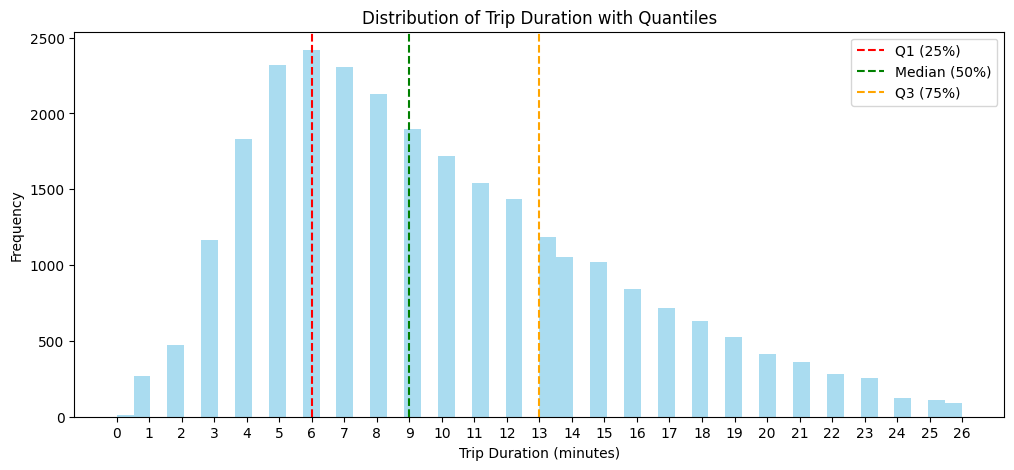

In [265]:
q1 = pdf['trip_duration'].quantile(0.25)
q2 = pdf['trip_duration'].quantile(0.50)
q3 = pdf['trip_duration'].quantile(0.75)

plt.figure(figsize=(12,5))
plt.hist(pdf['trip_duration'], bins=50, alpha=0.7, color='skyblue')

plt.axvline(q1, color='red', linestyle='--', label='Q1 (25%)')
plt.axvline(q2, color='green', linestyle='--', label='Median (50%)')
plt.axvline(q3, color='orange', linestyle='--', label='Q3 (75%)')

x_min, x_max = pdf['trip_duration'].min(), pdf['trip_duration'].max()
plt.xticks(np.arange(x_min, x_max+1, step=5))
x_min, x_max = pdf['trip_duration'].min(), pdf['trip_duration'].max()
plt.xticks(np.arange(x_min, x_max+1, step=1))
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Duration with Quantiles')
plt.legend()
plt.show()

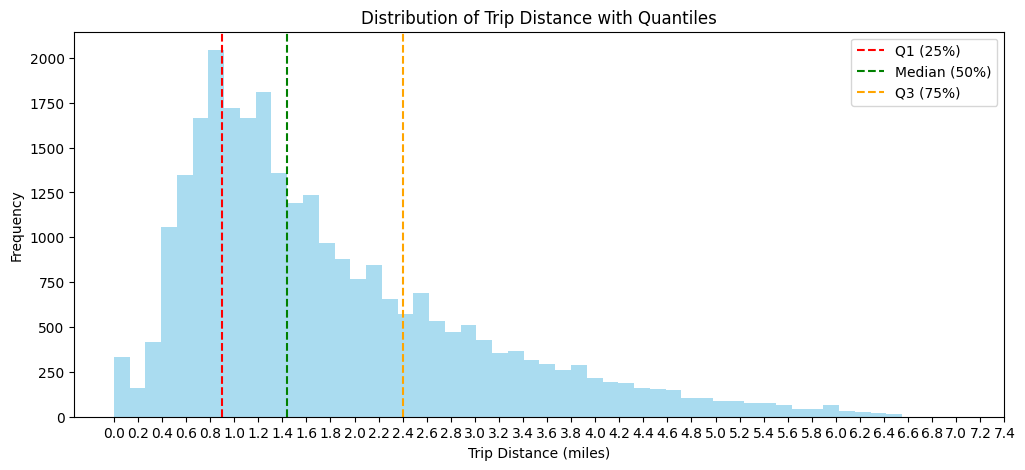

In [267]:
q1 = pdf['trip_distance'].quantile(0.25)
q2 = pdf['trip_distance'].quantile(0.50)
q3 = pdf['trip_distance'].quantile(0.75)

plt.figure(figsize=(12,5))
plt.hist(pdf['trip_distance'], bins=50, alpha=0.7, color='skyblue')

plt.axvline(q1, color='red', linestyle='--', label='Q1 (25%)')
plt.axvline(q2, color='green', linestyle='--', label='Median (50%)')
plt.axvline(q3, color='orange', linestyle='--', label='Q3 (75%)')

x_min, x_max = pdf['trip_distance'].min(), pdf['trip_distance'].max()
plt.xticks(np.arange(x_min, x_max+1, step=5))
x_min, x_max = pdf['trip_distance'].min(), pdf['trip_distance'].max()
plt.xticks(np.arange(x_min, x_max+1, step=0.2
                ))
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Distance with Quantiles')
plt.legend()
plt.show()

In [227]:
pq = pd.read_parquet('green_tripdata_2017-01.parquet')
print(pq.head())
print(pq.dtypes)

   VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2017-01-01 00:23:36   2017-01-01 00:24:08                  N   
1         2  2017-01-01 00:21:40   2017-01-01 00:23:13                  N   
2         2  2017-01-01 00:40:19   2017-01-01 00:45:31                  N   
3         2  2017-01-01 00:57:28   2017-01-01 01:07:40                  N   
4         1  2017-01-01 00:17:55   2017-01-01 00:30:38                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0           1             7             7                1           0.00   
1           1            49            49                1           0.19   
2           1            37            37                1           0.85   
3           1           225           188                1           1.68   
4           1            66            14                1           6.20   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount ehail_fee  \
0   